https://www.kaggle.com/datasets/andrewmvd/animal-faces

### Импорт всех необходимых библиотек

In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import os

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision import transforms
from torchvision.models import vgg16
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import classification_report
from torch.optim.lr_scheduler import ReduceLROnPlateau
from albumentations import Compose, RandomCrop, CenterCrop, Normalize, Resize, RandomCrop, HorizontalFlip, Normalize, pytorch

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### 1. Вычисление средних и дисперсий

In [3]:
train_dataset = ImageFolder(
    root=os.path.join(os.getcwd(),'/kaggle/input/animal-faces/afhq/train'),
    transform=transforms.Compose([
        transforms.Resize(size=256),
        # Изменение размера с сохранением соотношения сторон и обрезка до размера 224x224
        transforms.RandomResizedCrop(size=224, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]))

In [4]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    drop_last=True
)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [5]:
inputs_mean = torch.zeros(3)
inputs_var = torch.zeros(3)
n_samples = 0

for inputs, targets in train_loader:
    batch_size = inputs.shape[0]
    inputs_mean += torch.mean(inputs, dim=(0,2,3)) * batch_size
    inputs_var += torch.var(inputs, dim=(0,2,3)) * batch_size
    n_samples += batch_size

In [6]:
train_mean = inputs_mean / n_samples
train_std = torch.sqrt(inputs_var / n_samples)

print('train dataset mean:', train_mean)
print('train dataset std:', train_std)

train dataset mean: tensor([0.4766, 0.4342, 0.3779])
train dataset std: tensor([0.2665, 0.2534, 0.2518])


### 2. Добавление аугментаций с помощью albumentations

In [7]:
train_transform = transforms.Compose([
    transforms.Resize(size=256),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=224, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
])

In [8]:
train_dataset = ImageFolder(root=os.path.join(os.getcwd(),'/kaggle/input/animal-faces/afhq/train'),
                            transform=train_transform
                           )

In [9]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=32,
                          shuffle=True,
                          num_workers=2,
                          pin_memory=True # если GPU, рекомендуется использовать pin_memory для ускорения загрузки данных
                         )

In [10]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std)
])

In [11]:
test_dataset = ImageFolder(root=os.path.join(os.getcwd(), '/kaggle/input/animal-faces/afhq/val'),
                           transform=test_transform
                          )

In [12]:
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=32,
                         shuffle=False,
                         num_workers=2,
                         pin_memory=True 
                        )

### 3. Импортирование и дообучение нейронной сети vgg16. Обучение и валидация

In [13]:
vgg = vgg16(pretrained=True)
for param in vgg.features.parameters():
    param.requires_grad = False
    
vgg.classifier[6] = nn.Linear(4096, 3)

vgg.to(device)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(vgg.classifier[6].parameters(), lr=3e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

### Сохранить контрольную точку модели


100%|██████████| 47/47 [00:15<00:00,  3.12it/s]


Epoch 1/10, Train Loss: 0.3991, Val Loss: 0.1020
Train Accuracy: 0.8931, Val Accuracy: 0.9940
Classification Report:


100%|██████████| 47/47 [00:13<00:00,  3.42it/s]


              precision    recall  f1-score   support

         cat       1.00      1.00      1.00       500
         dog       1.00      0.98      0.99       500
        wild       0.98      1.00      0.99       500

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500



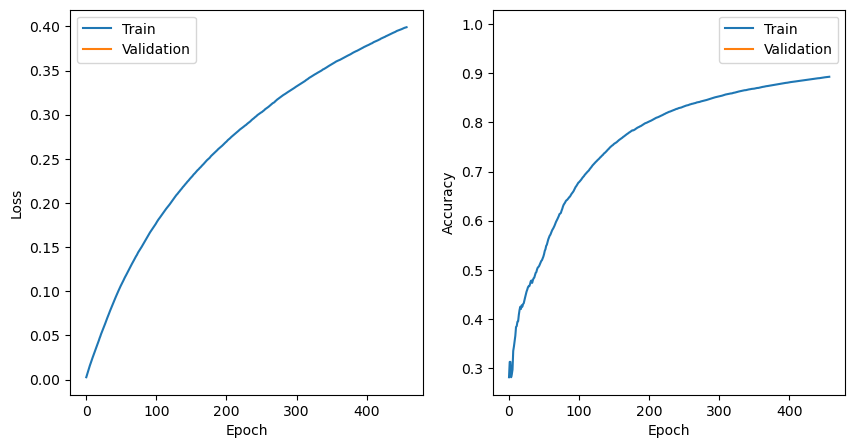

100%|██████████| 47/47 [00:13<00:00,  3.44it/s]


Epoch 2/10, Train Loss: 0.1230, Val Loss: 0.0484
Train Accuracy: 0.9791, Val Accuracy: 0.9953
Classification Report:


100%|██████████| 47/47 [00:13<00:00,  3.57it/s]


              precision    recall  f1-score   support

         cat       1.00      1.00      1.00       500
         dog       1.00      0.99      0.99       500
        wild       0.99      1.00      0.99       500

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



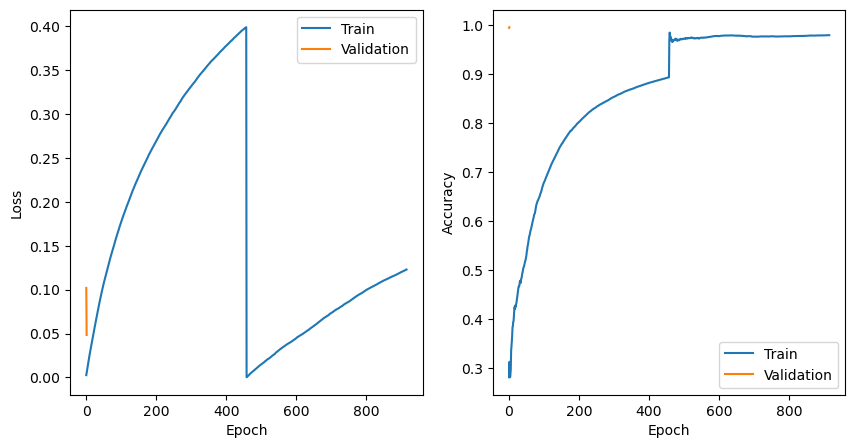

100%|██████████| 47/47 [00:12<00:00,  3.68it/s]


Epoch 3/10, Train Loss: 0.0819, Val Loss: 0.0336
Train Accuracy: 0.9830, Val Accuracy: 0.9967
Classification Report:


100%|██████████| 47/47 [00:13<00:00,  3.56it/s]


              precision    recall  f1-score   support

         cat       1.00      1.00      1.00       500
         dog       1.00      0.99      0.99       500
        wild       0.99      1.00      0.99       500

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



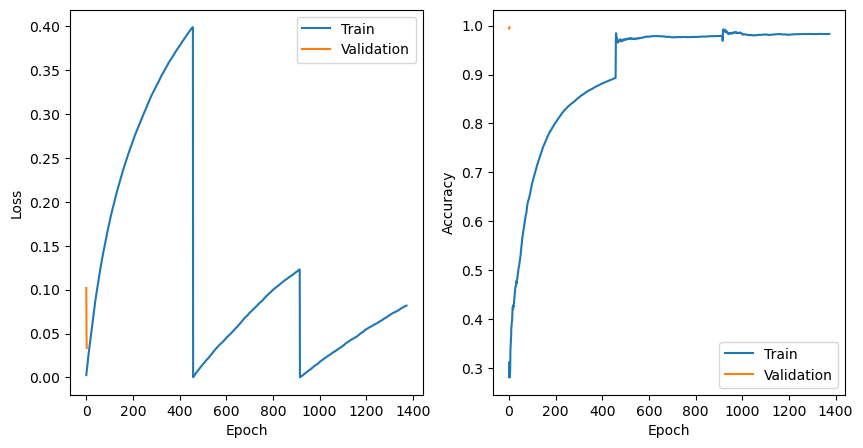

100%|██████████| 47/47 [00:13<00:00,  3.57it/s]


Epoch 4/10, Train Loss: 0.0656, Val Loss: 0.0267
Train Accuracy: 0.9843, Val Accuracy: 0.9953
Classification Report:


100%|██████████| 47/47 [00:13<00:00,  3.58it/s]


              precision    recall  f1-score   support

         cat       1.00      1.00      1.00       500
         dog       1.00      0.99      1.00       500
        wild       0.99      1.00      1.00       500

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



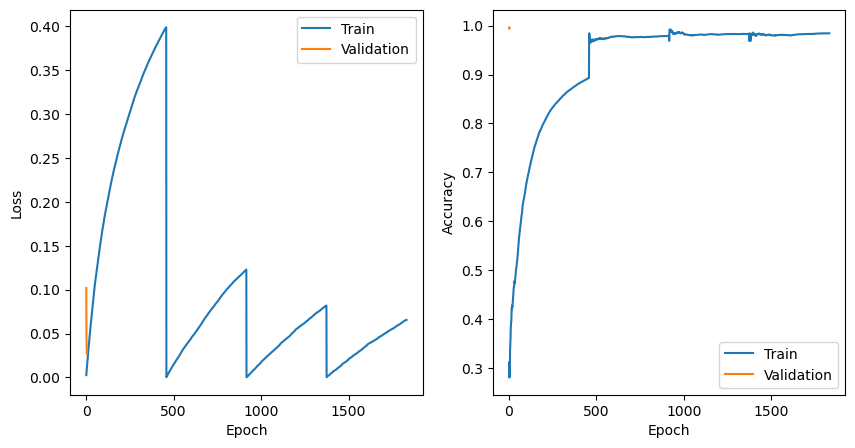

100%|██████████| 47/47 [00:12<00:00,  3.67it/s]


Epoch 5/10, Train Loss: 0.0543, Val Loss: 0.0217
Train Accuracy: 0.9861, Val Accuracy: 0.9973
Classification Report:


100%|██████████| 47/47 [00:12<00:00,  3.67it/s]


              precision    recall  f1-score   support

         cat       1.00      1.00      1.00       500
         dog       1.00      0.99      1.00       500
        wild       0.99      1.00      1.00       500

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



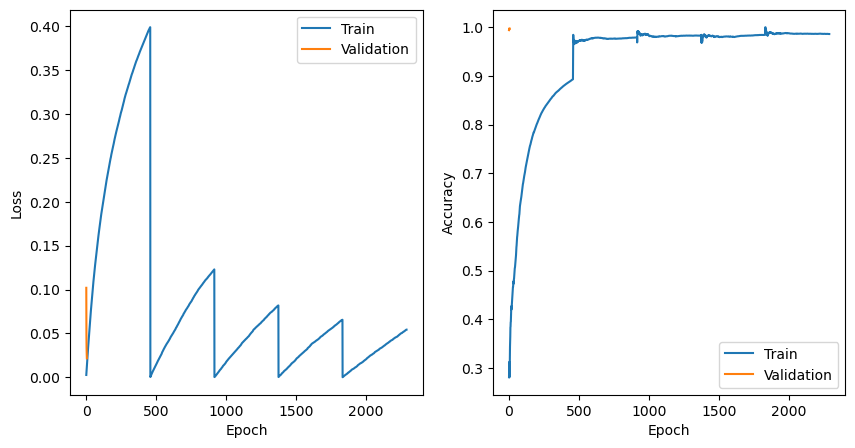

100%|██████████| 47/47 [00:12<00:00,  3.62it/s]


Epoch 6/10, Train Loss: 0.0486, Val Loss: 0.0199
Train Accuracy: 0.9873, Val Accuracy: 0.9973
Classification Report:


100%|██████████| 47/47 [00:13<00:00,  3.54it/s]


              precision    recall  f1-score   support

         cat       1.00      1.00      1.00       500
         dog       1.00      0.99      0.99       500
        wild       0.99      1.00      0.99       500

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



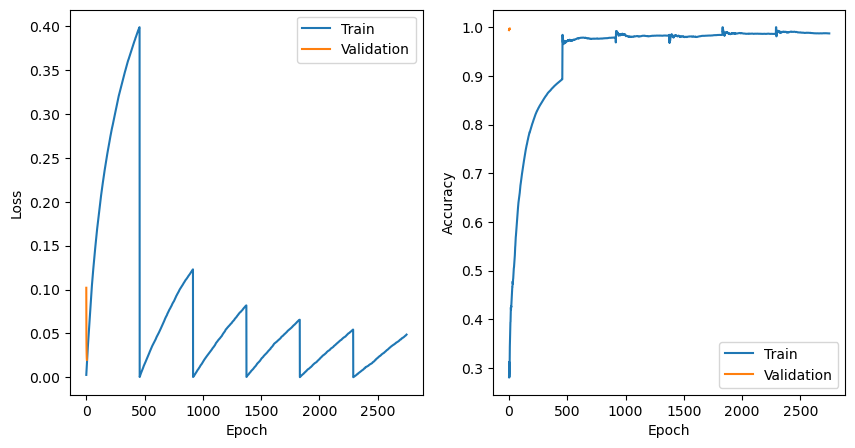

100%|██████████| 47/47 [00:13<00:00,  3.60it/s]


Epoch 7/10, Train Loss: 0.0455, Val Loss: 0.0179
Train Accuracy: 0.9874, Val Accuracy: 0.9973
Classification Report:


100%|██████████| 47/47 [00:12<00:00,  3.69it/s]


              precision    recall  f1-score   support

         cat       1.00      1.00      1.00       500
         dog       1.00      0.99      1.00       500
        wild       0.99      1.00      1.00       500

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



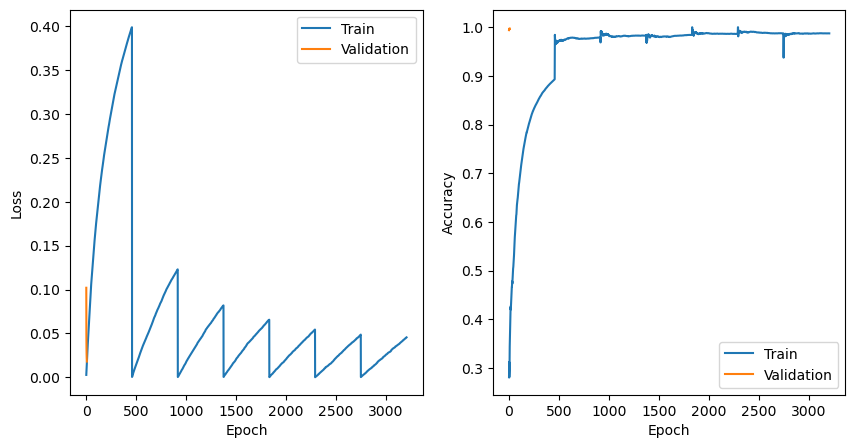

100%|██████████| 47/47 [00:12<00:00,  3.69it/s]


Epoch 8/10, Train Loss: 0.0413, Val Loss: 0.0157
Train Accuracy: 0.9889, Val Accuracy: 0.9967
Classification Report:


100%|██████████| 47/47 [00:13<00:00,  3.53it/s]


              precision    recall  f1-score   support

         cat       1.00      1.00      1.00       500
         dog       1.00      1.00      1.00       500
        wild       0.99      1.00      1.00       500

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



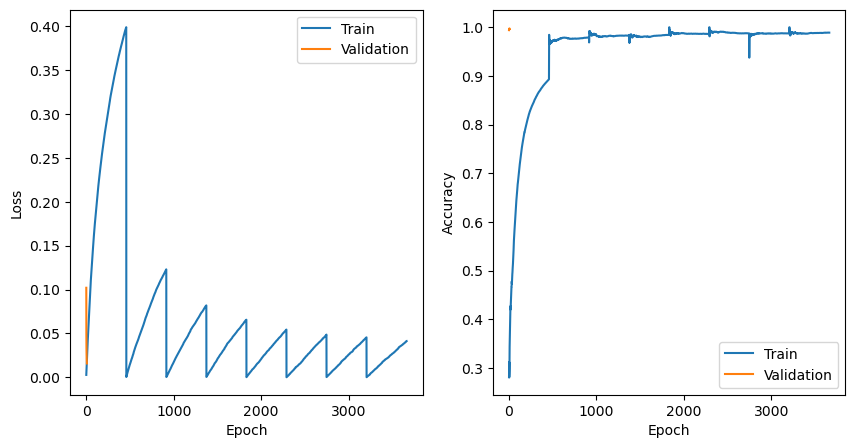

100%|██████████| 47/47 [00:13<00:00,  3.49it/s]


Epoch 9/10, Train Loss: 0.0384, Val Loss: 0.0143
Train Accuracy: 0.9877, Val Accuracy: 0.9980
Classification Report:


100%|██████████| 47/47 [00:13<00:00,  3.60it/s]


              precision    recall  f1-score   support

         cat       1.00      1.00      1.00       500
         dog       1.00      1.00      1.00       500
        wild       1.00      1.00      1.00       500

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



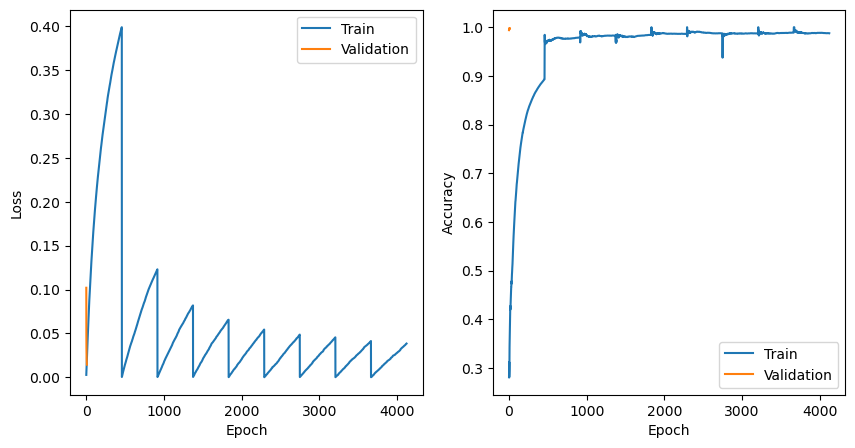

100%|██████████| 47/47 [00:12<00:00,  3.68it/s]


Epoch 10/10, Train Loss: 0.0364, Val Loss: 0.0139
Train Accuracy: 0.9895, Val Accuracy: 0.9980
Classification Report:


100%|██████████| 47/47 [00:13<00:00,  3.53it/s]


              precision    recall  f1-score   support

         cat       1.00      1.00      1.00       500
         dog       1.00      1.00      1.00       500
        wild       1.00      1.00      1.00       500

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



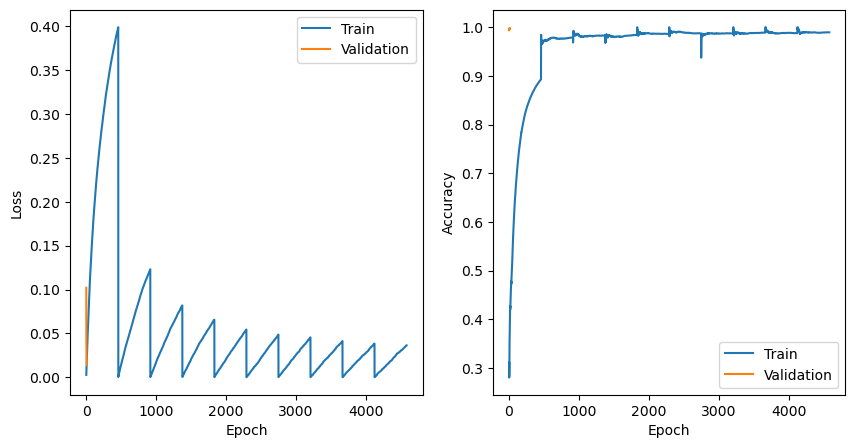

In [15]:
num_epochs = 10

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    vgg.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0
    for inputs, targets in tqdm(train_loader, total=len(train_loader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = vgg(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        total_correct += (torch.argmax(outputs, 1) == targets).sum().item()
        total_samples += targets.size(0)
        train_losses.append(train_loss)
        train_accuracy = total_correct / total_samples
        train_accuracies.append(train_accuracy)

    vgg.eval()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, total=len(test_loader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = vgg(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            val_loss = running_loss / len(test_loader.dataset)
            total_correct += (torch.argmax(outputs, 1) == targets).sum().item()
            total_samples += targets.size(0)
        val_losses.append(val_loss)
        val_accuracy = total_correct / total_samples
        val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print(f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")
    print("Classification Report:")
    predictions = []
    test_targets = []
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, total=len(test_loader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = vgg(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
            test_targets.extend(targets.cpu().numpy())

    print(classification_report(y_true=test_targets, y_pred=predictions, target_names=test_dataset.classes))

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train')
    plt.plot(val_accuracies, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [16]:
best_val_loss = float('inf')
if min(val_losses) < best_val_loss:
    best_val_loss = min(val_losses)
    model_name = "my_model"
    checkpoint_path = f"{model_name}_best.pth"
    torch.save(vgg.state_dict(), checkpoint_path)

**Выводы:**

Результаты обучения модели:

- Модель обучалась на 3 классах: cat, dog, wild

- Данные были разделены на тренировочную и валидационную выборки

- Модель обучалась в течение 10 эпох

- В процессе обучения достигнута высокая точность (accuracy) на обучающих данных и на валидационных данных

- Модель показала высокие показатели точности и f1-score для каждого класса на валидационной выборке

- Модель продолжает улучшать свои результаты по мере увеличения количества эпох обучения, пока не достигнет максимального значения точности.